In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import networkx as nx
import mygene
import torch

In [2]:
current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Data', 'RNA_dataset_tabular_R3.csv'))

# expression data
tabular_data = pd.read_csv(somepath, sep = ',', index_col = 0)
tabular_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,SLC17A1,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP,WNT16,PFS,CENSOR
id,,,,,,,,,,,,,,,,,,,,,
X00936b9285d6b8665ae9122993fb8e91,6.10,4.38,3.07,6.14,4.70,7.52,4.93,8.37,6.21,5.69,...,4.47,7.07,5.23,4.08,8.68,7.09,4.94,0.01,4.172485,0.0
X105622fadc33f23755ac2df823110aca,5.07,3.33,1.73,5.11,5.62,6.58,4.34,7.42,6.15,4.86,...,4.45,7.40,6.84,2.84,6.08,6.56,4.61,0.01,16.591376,1.0
Xe44f39747a8e84b02b4cb24659312144,6.13,4.41,3.23,6.32,5.57,8.02,5.14,7.55,6.87,6.27,...,2.94,6.66,5.81,4.16,6.33,7.14,8.42,0.01,11.104723,0.0
X293dd1284496215e9a0eca9f17a98e7e,5.82,4.30,3.44,6.45,4.86,7.45,4.90,8.39,6.83,5.70,...,0.83,6.67,5.27,4.12,6.97,6.73,6.28,0.01,14.028747,1.0
X01ed7190ce00862696edbf047b542045,6.15,4.21,3.90,5.93,4.43,7.60,4.74,8.31,6.38,5.94,...,6.70,6.53,5.84,4.35,5.67,6.66,4.93,0.01,12.418891,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X50772aa64efb859960b20f8801cd6f58,6.27,3.78,3.98,5.95,4.66,7.18,4.61,8.04,6.62,5.80,...,7.81,7.26,6.15,3.52,5.92,6.74,5.48,0.01,4.271047,0.0
X91bcd3067a1a7954692d836515e04869,6.12,3.94,3.25,6.09,4.98,7.32,5.02,8.21,6.71,5.89,...,0.01,6.38,5.20,4.05,7.84,7.59,7.59,0.01,2.496920,0.0
Xc7439a06ffa32b313b0ec1b987b992a2,5.91,3.62,3.34,5.80,8.86,8.69,4.52,8.15,5.77,6.85,...,7.31,6.76,7.12,3.25,6.81,6.82,5.27,0.01,6.505133,1.0


In [7]:
print(set(tabular_data.dtypes))

{dtype('float64')}


In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = tabular_data.drop(columns=['PFS'])
Y = tabular_data['PFS']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns, index = X_test.index)

Y_train

id
Xf7ee4a331a8fd70edc240dff978c170d    13.897331
X5cabb9f0afcc6ec89f28a72e66b75c5b     3.909651
X2069a43cf26725e339dae5a64490a17f     1.379877
X3cdb45cfe9ffaac83f36c75e4af759e6     3.745380
X8783adc097e910b52c11f50e2a4aff2a     9.626283
                                       ...    
Xe1b0f87c25889df31bc0fe76a68853b6    12.517454
X502dfff1180e1952d964196c8493633b     0.032854
Xfdb742505b30978af60b426c93a32f9e     5.585216
X5db2ba740f908fe3a3e6832d48949346     1.412731
X490b3aaf0b34d71712e894ca670bff00     7.030801
Name: PFS, Length: 580, dtype: float64

In [34]:
torch.tensor(Y_train.values)

tensor([13.8973,  3.9097,  1.3799,  3.7454,  9.6263, 19.3511,  6.8994,  8.5749,
         1.6099,  6.9651,  5.6509,  4.2382,  2.5626,  8.4107,  1.2485,  1.4127,
         7.1622,  4.2053,  6.9322,  8.3121,  7.0308,  8.3450,  8.3450,  6.9322,
        12.3203,  1.4127,  0.4928,  1.4127, 11.3018,  2.8583,  1.4127,  8.2464,
         4.1725,  6.9322,  0.0329,  4.1725,  6.8994,  8.1150, 13.8316, 18.0041,
        16.6571,  2.8583,  4.1725,  1.4127,  4.4353,  5.4209, 10.8419,  2.7926,
         1.4127,  3.0226,  5.8480,  6.7680, 11.0719,  8.0493,  2.9240,  2.6283,
        14.0616, 12.6160,  2.7926, 12.2546,  5.5524,  4.2053,  6.9322,  6.9322,
         8.3121,  8.3121,  5.6181, 12.5832,  4.8296,  4.1396,  9.9220,  4.1068,
         8.3778, 11.1704,  4.1725,  8.3121,  1.4456,  5.6181, 20.7967,  3.2526,
        13.8645,  1.5113,  1.4456,  9.6591,  9.6920,  9.7577, 12.4517, 15.3101,
         9.6920,  5.7823,  7.7207,  7.0965,  9.5934, 23.6222,  2.7926,  1.5770,
         5.5524,  1.3799,  2.8583, 11.17

In [30]:
dataobj = X_train.iloc[0]
dataobj = torch.tensor(dataobj.values)
dataobj.reshape(-1, len(dataobj))

tensor([[0.6465, 0.4970, 0.4626,  ..., 0.4338, 0.3231, 0.0000]],
       dtype=torch.float64)

In [7]:
current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Data', 'RNA_dataset_graph_R3.pkl'))

with open(somepath, 'rb') as f:
    loaded_object = pickle.load(f)

In [8]:
loaded_object

In [38]:
x = [[[1,2,3],[4,5,6],[7,8,9]],[[1,2,3],[4,5,6],[7,8,9]],[[1,2,3],[4,5,6]]]
x

[[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
 [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
 [[1, 2, 3], [4, 5, 6]]]

In [42]:
[j for i in x for j in i]

[[1, 2, 3],
 [4, 5, 6],
 [7, 8, 9],
 [1, 2, 3],
 [4, 5, 6],
 [7, 8, 9],
 [1, 2, 3],
 [4, 5, 6]]

In [44]:
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

X, y = load_breast_cancer()
y

array([( True,  723.), (False, 6591.), ( True,  524.), (False, 6255.),
       ( True, 3822.), (False, 6507.), (False, 5947.), (False, 5816.),
       (False, 6007.), ( True, 1233.), ( True, 1136.), (False, 5984.),
       (False, 6249.), ( True, 4066.), ( True,  690.), ( True,  994.),
       ( True,  434.), ( True, 1743.), ( True, 2863.), (False, 5693.),
       (False, 5823.), (False, 5785.), (False, 5661.), (False, 2909.),
       ( True, 1171.), (False, 5110.), (False, 5533.), (False, 5571.),
       (False, 5519.), (False, 5379.), (False, 4675.), (False, 4652.),
       (False, 4227.), ( True,  910.), (False, 4472.), ( True, 1206.),
       (False, 7057.), (False,  958.), (False, 5359.), (False, 5945.),
       (False, 5651.), ( True,  528.), ( True,  796.), (False, 5685.),
       ( True, 1023.), (False, 4791.), (False, 1215.), (False, 3779.),
       (False, 5306.), (False, 5678.), ( True,  421.), (False, 5612.),
       ( True, 3121.), (False, 1104.), (False, 4691.), (False, 5238.),
      

In [2]:
import matplotlib.pyplot as plt

In [14]:
start = 0.0001
stop = 0.1
step = 0.0001

# Generate the linearly spaced numbers
linear_numbers = np.arange(start, stop + step, step)
linear_numbers

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039, 0.004 ,
       0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047, 0.0048,
       0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055, 0.0056,
       0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063, 0.0064,
       0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071, 0.0072,
       0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.008 ,
       0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087, 0.0088,
       0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095, 0.0096,
       0.0097, 0.0098, 0.0099, 0.01  , 0.0101, 0.0102, 0.0103, 0.0104,
       0.0105, 0.0106, 0.0107, 0.0108, 0.0109, 0.011 , 0.0111, 0.0112,
      

In [78]:
data_tr = {'MSE' : [], 'SPARSE': [], 'SLAT': []}
for i in range(20):
    data_tr['MSE'] += [i]
    data_tr['SPARSE'] += [i+0.3]
    data_tr['SLAT'] += [i+2]
data_tr

{'MSE': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'SPARSE': [0.3,
  1.3,
  2.3,
  3.3,
  4.3,
  5.3,
  6.3,
  7.3,
  8.3,
  9.3,
  10.3,
  11.3,
  12.3,
  13.3,
  14.3,
  15.3,
  16.3,
  17.3,
  18.3,
  19.3],
 'SLAT': [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21]}

In [68]:
combined_tr = [sum(values) for values in zip(*[data_tr[key] for key in data_tr.keys()])]
combined_tr

[0.43,
 3.4299999999999997,
 6.43,
 9.43,
 12.43,
 15.43,
 18.43,
 21.43,
 24.43,
 27.43,
 30.43,
 33.43,
 36.43,
 39.43,
 42.43,
 45.43,
 48.42999999999999,
 51.42999999999999,
 54.42999999999999,
 57.42999999999999]

In [71]:
data_val = {'MSE' : [], 'SPARSE': [], 'SLAT': []}
for i in range(20):
    data_val['MSE'] += [i+4]
    data_val['SPARSE'] += [i+0.6]
    data_val['SLAT'] += [i+0.3]
data_val

{'MSE': [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 'SPARSE': [0.6,
  1.6,
  2.6,
  3.6,
  4.6,
  5.6,
  6.6,
  7.6,
  8.6,
  9.6,
  10.6,
  11.6,
  12.6,
  13.6,
  14.6,
  15.6,
  16.6,
  17.6,
  18.6,
  19.6],
 'SLAT': [0.3,
  1.3,
  2.3,
  3.3,
  4.3,
  5.3,
  6.3,
  7.3,
  8.3,
  9.3,
  10.3,
  11.3,
  12.3,
  13.3,
  14.3,
  15.3,
  16.3,
  17.3,
  18.3,
  19.3]}

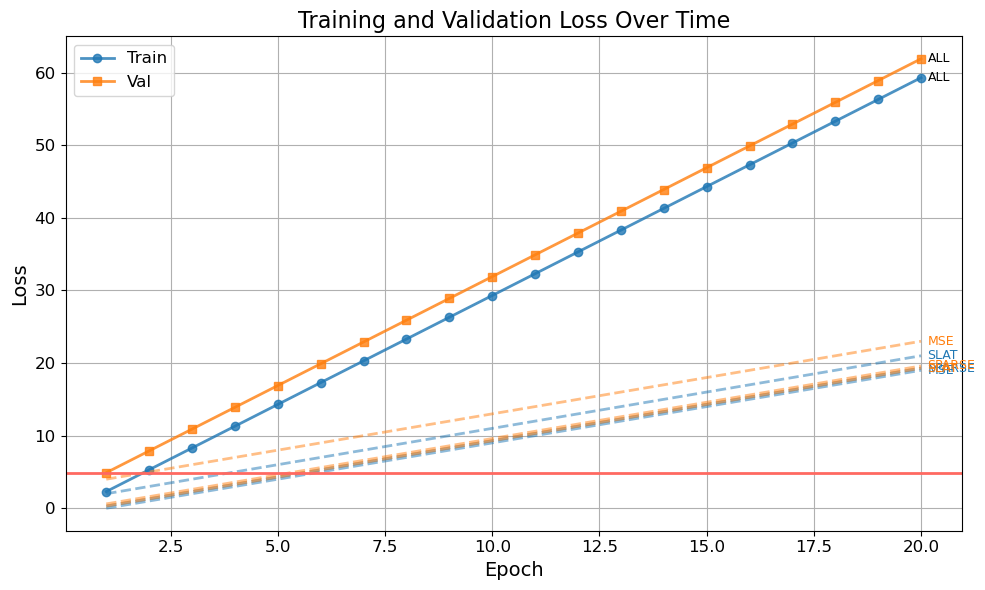

In [104]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, 21)

combined_tr = [sum(values) for values in zip(*[data_tr[key] for key in data_tr.keys()])]
combined_val = [sum(values) for values in zip(*[data_val[key] for key in data_val.keys()])]

bestVal = min(combined_val)

plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(epochs, combined_tr, label="Train", marker='o', linestyle='-', color='#1f77b4', linewidth=2, alpha = 0.8)  # Customize train curve with softer blue color
plt.plot(epochs, combined_val, label="Val", marker='s', linestyle='-', color='#ff7f0e', linewidth=2, alpha = 0.8)
plt.text(epochs[-1] + 0.15, combined_tr[-1], 'ALL', verticalalignment = 'center', fontsize = 9)
plt.text(epochs[-1] + 0.15, combined_val[-1], 'ALL', verticalalignment = 'center', fontsize = 9)

for idx,key in enumerate(list(data_tr.keys())):
    plt.plot(epochs, data_tr[key], linestyle='--', color='#1f77b4', linewidth=2, alpha = 0.5)
    plt.text(epochs[-1] + 0.15, data_tr[key][-1], key, verticalalignment = 'center', fontsize = 9, color = '#1f77b4')

for idx,key in enumerate(list(data_val.keys())):
    plt.plot(epochs, data_val[key], linestyle='--', color='#ff7f0e', linewidth=2, alpha = 0.5)
    plt.text(epochs[-1] + 0.15, data_val[key][-1], key, verticalalignment = 'center', fontsize = 9, color = '#ff7f0e')

plt.axhline(bestVal, linestyle='-', color='#FF6961', linewidth=2, alpha = 1)

plt.title("Training and Validation Loss Over Time", fontsize=16)
plt.xlabel("Epoch", fontsize=14)  
plt.ylabel("Loss", fontsize=14)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.legend(fontsize=12) 
plt.grid(True)  
plt.tight_layout()  

plt.show()


In [63]:
test = {'A': []}
test[list(test.keys())[0]]

[]

In [45]:
a = [np.array([1,2,3]),np.array([4,5,6]),np.array([7,8,9])]
idxs = [0,1]
[x for idx in idxs for x in [a[idx]]]

[array([1, 2, 3]), array([4, 5, 6])]

In [62]:
import pandas as pd
import numpy as np

# Define the data for the DataFrame
data = {
    'Feature1': np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]),
    'Feature4': np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]),
    'Feature5': np.array([2, 8, 5, 3, 2, 2, 8, 5, 3, 2]),
    'Feature6': np.array([2, 1, 5, 32, 2, 2, 1, 5, 32, 2]),
    'Feature7': np.array([2, 3, 4, 0, 2, 2, 3, 4, 0, 2])
}

# Create the DataFrame
df = pd.DataFrame(data)

print(df)


   Feature1  Feature4  Feature5  Feature6  Feature7
0         1       0.1         2         2         2
1         2       0.2         8         1         3
2         3       0.3         5         5         4
3         4       0.4         3        32         0
4         5       0.5         2         2         2
5         1       0.1         2         2         2
6         2       0.2         8         1         3
7         3       0.3         5         5         4
8         4       0.4         3        32         0
9         5       0.5         2         2         2


In [63]:
list(data.values())

[array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]),
 array([2, 8, 5, 3, 2, 2, 8, 5, 3, 2]),
 array([ 2,  1,  5, 32,  2,  2,  1,  5, 32,  2]),
 array([2, 3, 4, 0, 2, 2, 3, 4, 0, 2])]

[[ -45.93055    28.835352]
 [ 194.68057   109.05402 ]
 [  42.049473 -213.49263 ]
 [-252.57896    28.669697]
 [ 105.68342    -9.885505]]


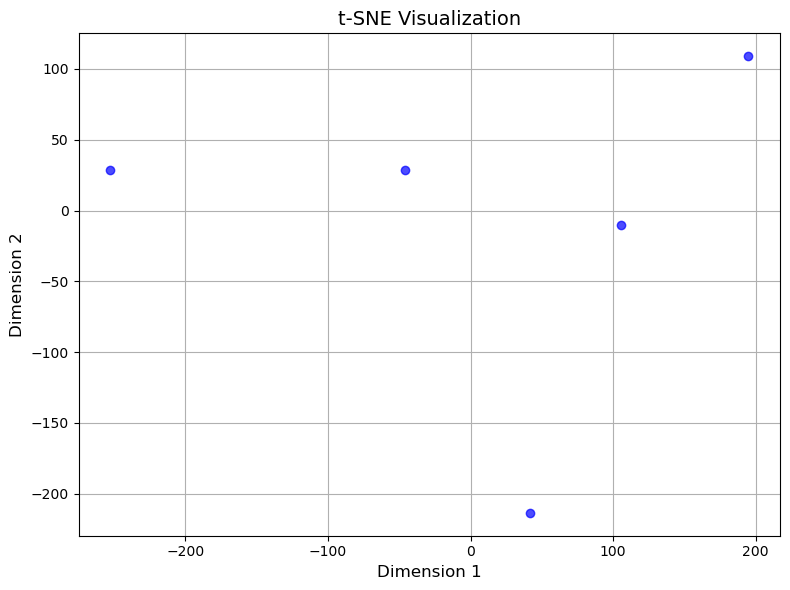

In [64]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vals = np.array(list(data.values()))
x_embedded = TSNE(n_components = 2, perplexity = 2).fit_transform(vals)

print(x_embedded)

plt.figure(figsize=(8, 6))  # Adjust the figure size

plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c='blue', alpha=0.7, label='Data Points')
plt.xlabel('Dimension 1', fontsize=12) 
plt.ylabel('Dimension 2', fontsize=12)
plt.title('t-SNE Visualization', fontsize=14)
#plt.legend(loc='best', fontsize=10) 
plt.grid(True)
plt.tight_layout()
plt.show()
